In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
df = pd.read_csv('Context.csv')

In [3]:
df.head()

,Text,Context/Topic
0,The eternal mystique of Goldman Sachs,Politics
1,Either you don't care enough to actually tell ...,Love
2,I am such an IDIOT.,Heavy Emotion
3,While lifting weights on Friday and doing bent...,Health
4,Something's watching me,Animals


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31386 entries, 0 to 31385
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           31386 non-null  object
 1   Context/Topic  31386 non-null  object
dtypes: object(2)
memory usage: 490.5+ KB


In [5]:
df['Context/Topic'].value_counts()

Heavy Emotion    3674
Religion         3466
Love             3229
Self             3105
Compliment       3061
Animals          2622
Health           2595
Education        2534
Joke             2476
Science          2428
Politics         2196
Name: Context/Topic, dtype: int64

In [6]:
df['Context/Topic'].unique()

array(['Politics', 'Love', 'Heavy Emotion', 'Health', 'Animals',
       'Science', 'Joke', 'Compliment', 'Religion', 'Self', 'Education'],
      dtype=object)

In [27]:
df['Context/Topic'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Context', 
                                                                title='Context distribution')

In [8]:
def print_plot(index):
    example = df[df.index == index][['Text', 'Context/Topic']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [9]:
print_plot(10)

Yea just gotta remember XD
Product: Compliment


In [10]:
print_plot(100)

However, He said that starting a relationship it’s a huge gamble and we could spend years trying to make it work and real love could pass us by.  That maybe he’d change his mind if we ever met.  He always talked about meeting but now he never mentions it.  
Product: Love


In [11]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Text_Clean'] = df['Text'].apply(clean_text)

In [12]:
df['Text_Clean'] = df['Text_Clean'].str.replace('\d+', '')

<ipython-input-12-761e5bf24e71>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [13]:
print_plot(10)

Yea just gotta remember XD
Product: Compliment


In [14]:
print_plot(100)

However, He said that starting a relationship it’s a huge gamble and we could spend years trying to make it work and real love could pass us by.  That maybe he’d change his mind if we ever met.  He always talked about meeting but now he never mentions it.  
Product: Love


In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Text_Clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 37828 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(df['Text_Clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (31386, 250)


In [17]:
Y = pd.get_dummies(df['Context/Topic']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (31386, 11)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28247, 250) (28247, 11)
(3139, 250) (3139, 11)


In [34]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
398/398 [==============================] - 313s 779ms/step - loss: 1.8731 - accuracy: 0.3553 - val_loss: 1.3213 - val_accuracy: 0.5600
Epoch 2/5
398/398 [==============================] - 320s 805ms/step - loss: 1.0471 - accuracy: 0.6582 - val_loss: 1.1654 - val_accuracy: 0.6227
Epoch 3/5
398/398 [==============================] - 322s 809ms/step - loss: 0.6744 - accuracy: 0.7916 - val_loss: 1.1908 - val_accuracy: 0.6361
Epoch 4/5
398/398 [==============================] - 314s 789ms/step - loss: 0.4708 - accuracy: 0.8583 - val_loss: 1.2905 - val_accuracy: 0.6358
Epoch 5/5
398/398 [==============================] - 319s 803ms/step - loss: 0.3561 - accuracy: 0.8925 - val_loss: 1.3524 - val_accuracy: 0.6333


In [37]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

99/99 [==============================] - 6s 57ms/step - loss: 1.4444 - accuracy: 0.6142
Test set
  Loss: 1.444
  Accuracy: 0.614


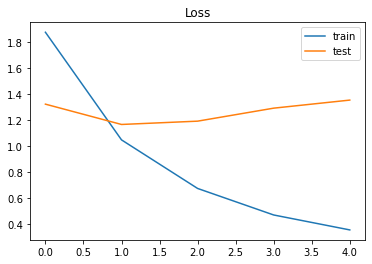

In [38]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

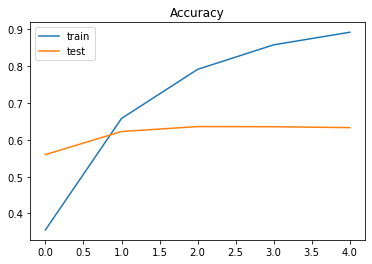

In [40]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Test with a new complaint.

In [54]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


In [60]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import numpy as np
import pickle
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
reconstructed_model = keras.models.load_model("model")
MAX_SEQUENCE_LENGTH = 250

new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = reconstructed_model.predict(padded)
labels = ['Animals', 'Compliment', 'Education', 'Health', 'Heavy Emotion', 'Joke',
       'Love', 'Politics', 'Religion', 'Science', 'Self']
print(labels[np.argmax(pred)],max(pred))

Self [0.00109373 0.01362233 0.21046883 0.01546395 0.02219755 0.06834423
 0.01254564 0.00797656 0.01019261 0.0325535  0.6055411 ]
